<a href="https://colab.research.google.com/github/konstanzer/brainpickings.org/blob/main/brain_pickings_NLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [475]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import plot_partial_dependence
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import en_core_web_sm
import spacy
from spacy import displacy

### 1.1 Make classes based on date
The reason for doing this classification may be to distinguish Maria's early and late writing style. Summer (June 21) 2014 is my dividing line. This date divides the total word count more or less evenly (I figured this date out in EDA.)

In [473]:
path = "data/articles.csv'"
url = "https://raw.githubusercontent.com/konstanzer/brainpickings.org/main/data/articles.csv"
df = pd.read_csv(url, index_col='index')
df.date = pd.to_datetime(df.date)

df["early"]=1
df.early[(df.date>'2014-06-20')]=0
df.tags = df.tags.str.replace(",", "")

#half errors were in this year originally
df = df[(df.date.dt.year != 2014)]

early, late = df.early.value_counts()[1], df.early.value_counts()[0]
early_stubs = np.argsort(df.words[df.early==1].values)[:early-late]
early_stubs += 1 #original index started at 1
df=df.drop(index=early_stubs)
df=df.reset_index(drop=True)

articles = df.title + df.content
tags = df.tags
#target for classifiers
y = df.early
y.value_counts()

1    1927
0    1927
Name: early, dtype: int64

In [ ]:
nlp = en_core_web_sm.load()
df["ents"] = str()
#use spacy to clean and group tags
for ix, tag in enumerate(tags):
  doc = nlp(tag)
  tag_str = str()
  for entity in doc.ents:
    tag_str += entity.text + " "
  df.ents[ix] = tag_str

In [ ]:
#SKIP replace names with dashed names in articles
"""
for ix, article in enumerate(articles):
  for ent in df.ents[ix].split(" "):
    if "-" in ent:
      #name = ent.split("-")[0]
      surname = ent.split("-")[-1:][0]
      if surname in article:
        article.replace(surname, ent)
"""

### 1.2 Feature Extraction with Tf-Idf vectorizer

NLTK stop words decreased accuracy and are sort of redundant with max_df. I did notice the model fitting to years mentioned in the text, which I don't want, because that isn't stylistic.
Using many stopwords is not good, e.g. 
'their', 'don', 've', 'or', 'if', 'he', 'she', 'to', 'they', 'him', 'her', 'them', 'has', 'have', 'been', 'with', 'will', 'on', 'his', 'hers', 'we', 'us', 'how', 'our', 'can' becuase these are building-blocks of style. On the other hand, a meaningless bigram uses two common words. Allowing for and all gave an accuracy boost, go figure. The model performs as well on common words as obscure ones. It can probably pick up many equally powerful patterns but none os vastly superior. Boost from adding "ve re to"

* INTERPRETABILITY is the GOAL for this model not accuracy (you would never need to guess the date of an article!)
* USE MORE n-grams!
* rank beta coefficients! feature importances all day
* if 2014 has all the errors, LEAVE IT OUT
* split then vectorize, not for feature interpretability but for reporting accurate metrics
* HOW tfidf works: it rewards a word for being loyal to a document and then punishes it if it has been sleeping around with all the documents
* INSIGHT: PREDICTING date is absurd. Are you making a tool to reattach lost dates to articles? That being the case, who cares about test data. I want to overfit to the style so I can interpret it as best as possible. And why delete stubs if you don't care about the confusion matrix? UNDO what you've done to preprocess. This is a simple style analysis.


In [ ]:
#do this before vectorizer
X_train, X_test, y_train, y_test = train_test_split(tags, y, test_size=0.2, #articles or tags
                                                    stratify=y, random_state=36)
stop_words = [str(year) for year in range(2000, 2022)]
stop_words += ['the', 'a', 'is', 'and', 'but', 'in', 'it', 'do', 'as', 'at', 've', 're',
              'to', 'll', 'public library',
               #'art', 'psychology', 'culture', 'out-of-print'
               #'science', 'history', 'philosophy', 'politics', 'design',
               #'illustration', 'technology', 'photography', 'creativity',
               #'writing', 'childrens-books', 'poetry', 'letters', 'music', 'picked',
               'you', 'he', 'her', 'my', 'they', 'wa', 'can',
               'your', 'book', 'she', 'u', 'love', 'about', 'so', 'if', 'ha',
               'who', 'into', 'like', 'their', 'had', 'than', 'will', 'only',
               'theree', 'when']

def tokenizer(text):
        tokens = [word for word in nltk.word_tokenize(text) if len(word)>1]
        return [WordNetLemmatizer().lemmatize(word) for word in tokens]

#chose metrics based on crossval scores
tfidf = TfidfVectorizer(max_features=10000,
                        tokenizer=tokenizer,
                        token_pattern=r"(?u)\S\S+",
                        min_df=2, #.04  tags: 2
                        max_df=.5, #.75   tags: .5
                        stop_words=stop_words,
                        ngram_range=(1,1)) #1,2

X_train = tfidf.fit_transform(X_train)
#all of the scikit-learn transformers maintain samples' ordering
X_train

<3083x700 sparse matrix of type '<class 'numpy.float64'>'
	with 14128 stored elements in Compressed Sparse Row format>

tags

In [ ]:
#sort coefficients, could pick up on events or names
vals = X_train.copy()
words = tfidf.get_feature_names()
ones = [np.mean(vec) for vec in zip(*vals.A[:y.value_counts()[1]])]
zeros = [np.mean(vec) for vec in zip(*vals.A[y.value_counts()[1]:])]
bow = pd.DataFrame([ones, zeros], columns=words)
bow1 = pd.Series(data=ones, index=words)
bow0 = pd.Series(data=zeros, index=words)
#trying to identify features that point to themes
most_early = bow1.sort_values(ascending=False)
most_late = bow0.sort_values(ascending=False)
diff = bow1 - bow0
more_early = diff.sort_values(ascending=False)
more_late = diff.sort_values(ascending=True)
feature_df = pd.DataFrame(data=[more_early.index, more_late.index,], 
                          index=["more_early", "more_late"])
feature_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699
more_early,technology,design,history,omnibus,poetry,best-of,data-visualization,astronomy,space,sustainability,software,vladimir-nabokov,albert-einstein,documentary,cookbook,the-universe-in-verse,erich-fromm,new-york,ted-ed,virginia-woolf,debbie-millman,food,nietzsche,nasa,emily-dickinson,maria-mitchell,city,ominus,diane-ackerman,photography,may-sarton,philosophy,hannah-arendt,carl-sagan,aldous-huxley,sociology,politics,math,alan-watts,art,...,daily-routines,emily-levine,sam-harris,stoicism,commencement,eudora-welty,good-to-know,henry-david-thoreau,health,public-domain,eleanor-roosevelt,james-joyce,annie-dillard,henry-beston,neuroscience,mark-twain,anais-nin,charles-darwin,interview,walt-whitman,maira-kalman,vincent-van-gogh,groundwood-books,marcel-proust,william-james,tree,childrens-books,diary,rachel-carson,soundcloud,vintage-childrens-books,writing,patti-smith,happiness,illustration,creativity,time,list,picked,psychology
more_late,psychology,picked,list,time,creativity,illustration,happiness,patti-smith,writing,vintage-childrens-books,soundcloud,rachel-carson,diary,childrens-books,tree,william-james,marcel-proust,groundwood-books,vincent-van-gogh,maira-kalman,walt-whitman,interview,charles-darwin,anais-nin,mark-twain,neuroscience,henry-beston,annie-dillard,james-joyce,eleanor-roosevelt,public-domain,health,henry-david-thoreau,good-to-know,eudora-welty,commencement,stoicism,sam-harris,emily-levine,daily-routines,...,art,alan-watts,math,politics,sociology,aldous-huxley,carl-sagan,hannah-arendt,philosophy,may-sarton,photography,diane-ackerman,ominus,city,maria-mitchell,emily-dickinson,nasa,nietzsche,food,debbie-millman,virginia-woolf,ted-ed,new-york,erich-fromm,the-universe-in-verse,cookbook,documentary,albert-einstein,vladimir-nabokov,software,sustainability,space,astronomy,data-visualization,best-of,poetry,omnibus,history,design,technology


content

### 1.3 Modeling
#### 1.3.1 Logistic regression

In [ ]:
X_train = StandardScaler().fit_transform(X_train.todense())
lr = LogisticRegression(solver="newton-cg")
lr.fit(X_train, y_train.ravel())
scores = cross_val_score(estimator=lr, X=X_train, y=y_train)
"%0.3f accuracy with std of %0.2f" % (scores.mean(), scores.std())

'0.855 accuracy with std of 0.01'

In [ ]:
"""
Indeed, np.abs(coef_) is an awful attempt at quantifying feature importance -
 a concept which doesn't really make much sense anyway in a multivariate setting 
 (i.e. the variables act jointly to make the prediction) unless your model does 
 variable selection, e.g. through sparsity. If the model promotes sparsity, 
 then you can discard the variables whose weights are zero, but that is technically
  all you can really do if you want to be rigorous. Some other models expose 
  feature_importance, and depending on the model this is a more or less univariate 
  measure of how well this feature explains dat – eickenberg
"""
lr.coef_

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       385
           1       0.95      0.95      0.95       386

    accuracy                           0.95       771
   macro avg       0.95      0.95      0.95       771
weighted avg       0.95      0.95      0.95       771



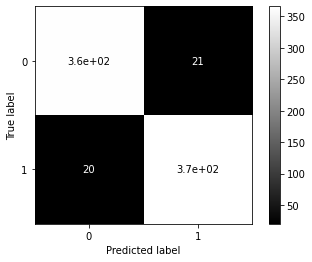

In [ ]:
X_test = tfidf.fit_transform(X_test)
#all of the scikit-learn transformers maintain samples' ordering
X_test = StandardScaler().fit_transform(X_test.todense())
lr = LogisticRegression()
lr.fit(X_test, y_test.ravel())
preds = lr.predict(X_test)

print(metrics.classification_report(y_test, preds))
metrics.plot_confusion_matrix(lr, X_test, y_test, cmap="gray");

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)
#from sklearn examples
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [ ]:
#from sklearn examples
average_precision = metrics.average_precision_score(y_test, preds)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
disp = metrics.plot_precision_recall_curve(lr, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision));

In [ ]:
errors = np.where(np.array(y_test) != preds)[0]
X_errors = X_test[errors]
errors_ix=[]
for ix, x1 in enumerate(X):
    for x2 in X_errors:
        if np.array_equal(x1,x2):
            errors_ix.append(ix)

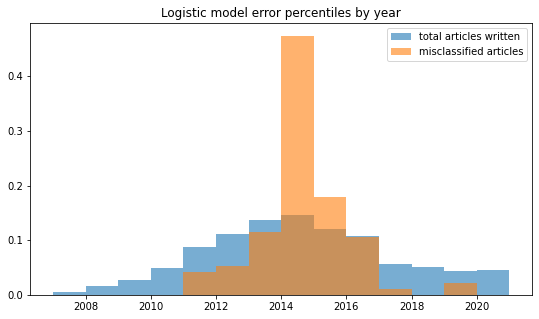

In [ ]:
#yeah! errorframe
error_df = df.iloc[errors_ix]

f,ax = plt.subplots(figsize=(9,5))
ax.hist(df.date.dt.year, alpha=.6, density=True, bins=14, label="total articles written")
ax.hist(error_df.date.dt.year, alpha=.6, density=True, bins=9, label="misclassified articles")
ax.set_title("Logistic model error percentiles by year")
ax.legend();

Had this result been anything else, I'd suspect foul play. The model is right 91 percent of the time almost out-of-the-box. I divided the corpus in half rather arbitrarily. Nothing changed suddenly to make Popova a different writer (that I know of.) Writing styles change gradually and the model appears to truly be capturing this shift very well. (Had there been no spike in the 2014 transistion, I would assume the model had found a way to fit to the date secretly coded somewhere in the text and then I would reach out to Dan Brown to decode the hidden symbology.)

## Decision Tree

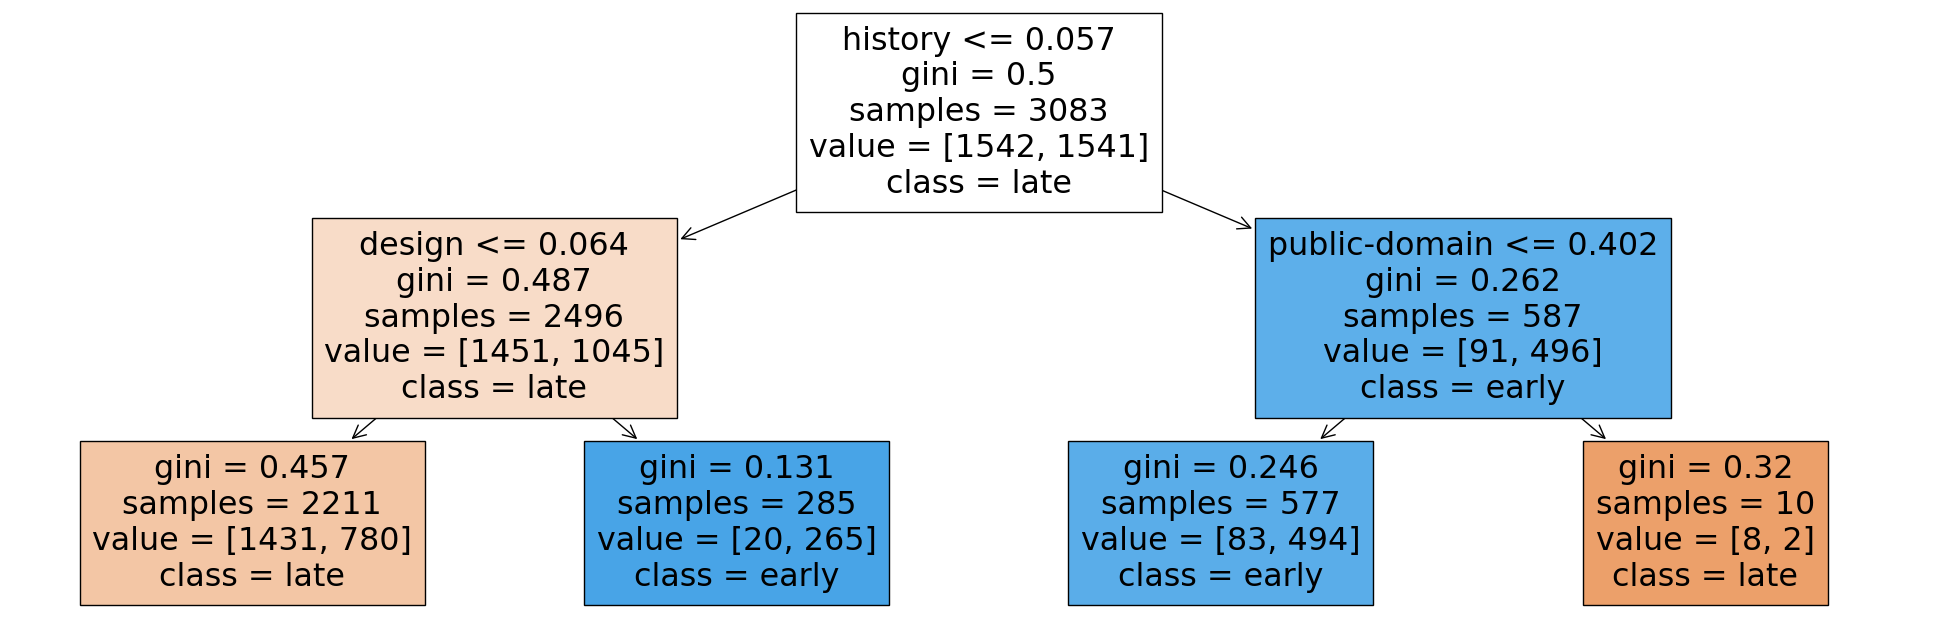

In [480]:

X_train, X_test, y_train, y_test = train_test_split(tags, y, test_size=0.2, #articles or tags
                                                    stratify=y, random_state=36)
#chose metrics based on crossval scores
tfidf = TfidfVectorizer(token_pattern=r"(?u)\S\S+",
                        min_df=2, #.04  tags: 2
                        max_df=.5) #.75   tags: .5
X_train = tfidf.fit_transform(X_train)
#all of the scikit-learn transformers maintain samples' ordering
X_train
dt = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
fig = plt.figure(figsize=(25,8))
plt.rcdefaults() #took forever to find so lines will show up
plot_tree(dt, filled=True, feature_names=tfidf.get_feature_names(), class_names=["late","early"]);
#plt.savefig("tagtree.png")
#files.download("tagtree.png")

if relevance of history is high and rel. of public-domain is low, we can say with 86% (494/(494+83)) certainty it's older. the confusion matrix has few errors when it predicts early
but lost of errors when it predicts new because new does not divide neatly. it needs a lot more branches to be accurate on new stuff. if relevance of history is low and rel. of design is high, we can say with 93% (265/285) certainty it's older.

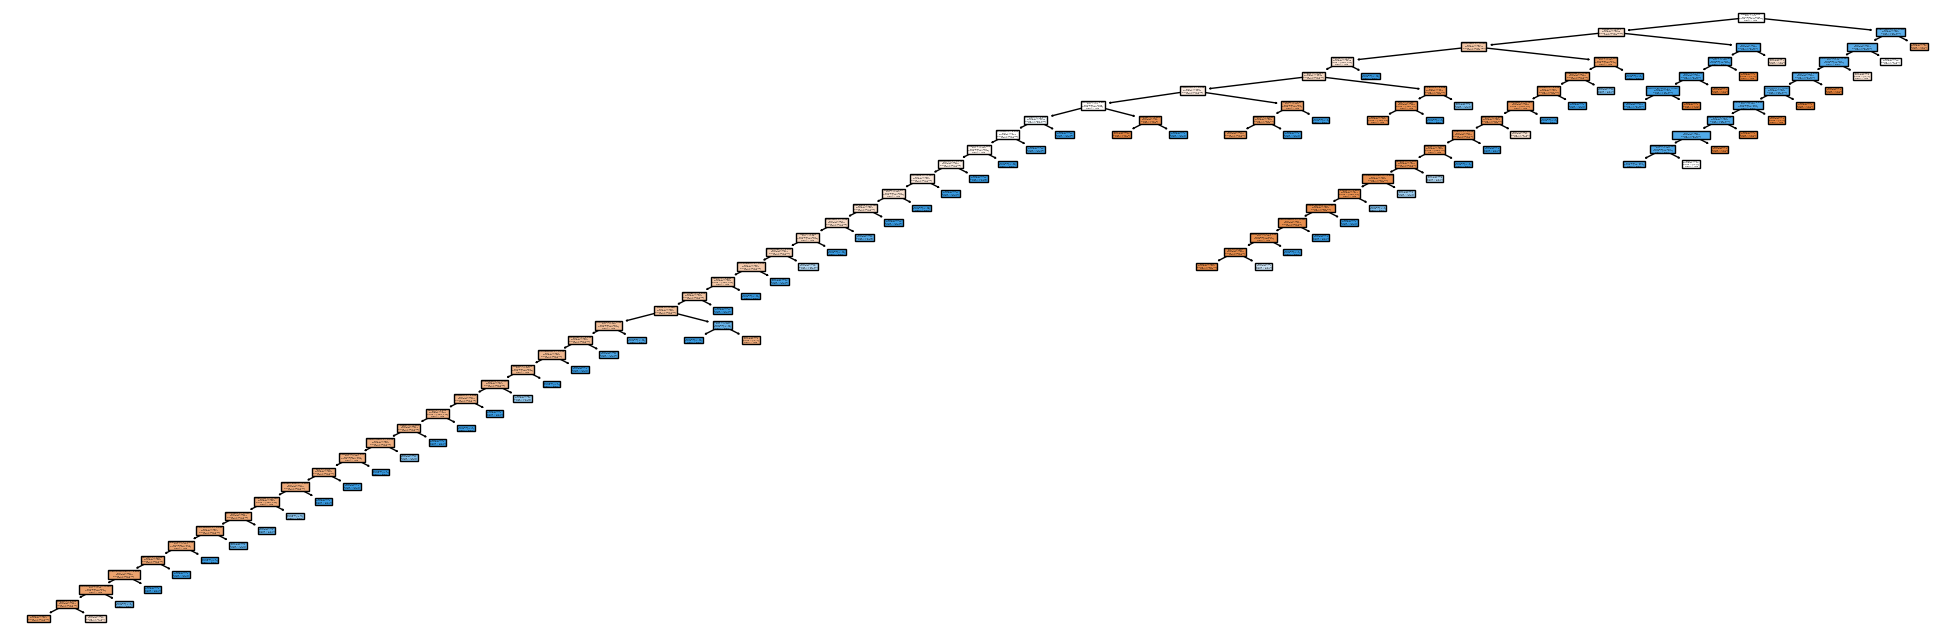

In [518]:
X_train, X_test, y_train, y_test = train_test_split(tags, y, test_size=0.2, #articles or tags
                                                    stratify=y, random_state=36)
ccpa=.001
#chose metrics based on crossval scores
tfidf = TfidfVectorizer(token_pattern=r"(?u)\S\S+",
                        min_df=2, #.04  tags: 2
                        max_df=.5) #.75   tags: .5
X_train = tfidf.fit_transform(X_train)
dt = DecisionTreeClassifier(ccp_alpha=ccpa).fit(X_train, y_train)
fig = plt.figure(figsize=(25,8))
plt.rcdefaults() #took forever to find; so lines will show up
plot_tree(dt, filled=True, feature_names=tfidf.get_feature_names(), class_names=["late","early"]);
#plt.savefig("tagtreefull.png")
#files.download("tagtreefull.png")

In [463]:
dt.get_depth()

41

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of nodes in the last tree is: 1 with ccp_alpha: 0.05602806378144565


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

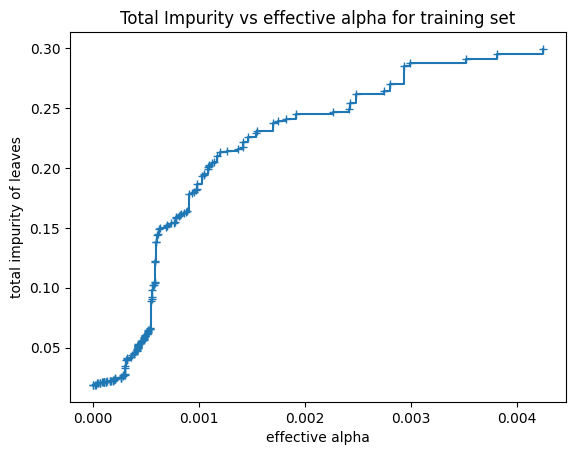

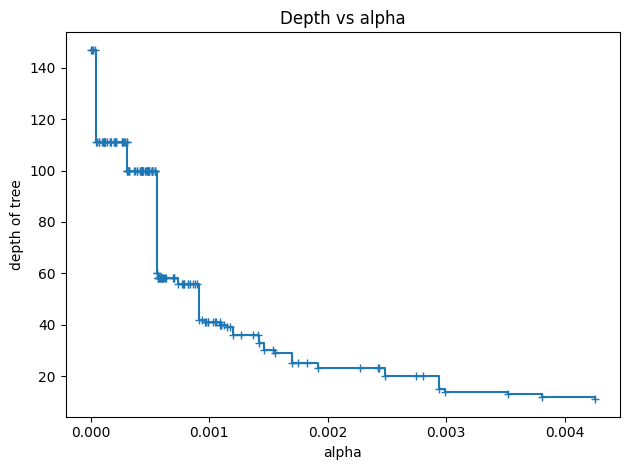

In [468]:
clf = DecisionTreeClassifier(random_state=36)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-10], impurities[:-10], marker='+', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.savefig("impurity.png")
files.download("impurity.png")

clfs = []
for ccp_alpha in ccp_alphas:
    clf2 = DecisionTreeClassifier(random_state=36, ccp_alpha=ccp_alpha)
    clf2.fit(X_train, y_train)
    clfs.append(clf2)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

clfs = clfs[:-10]
ccp_alphas = ccp_alphas[:-10]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots()
ax.plot(ccp_alphas, depth, marker='+', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("depth of tree")
ax.set_title("Depth vs alpha")
fig.tight_layout()
plt.savefig("depth.png")
files.download("depth.png")
plt.show()

0.9844357976653697
0.9844559585492227 0.9844559585492227


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 400x400 with 0 Axes>

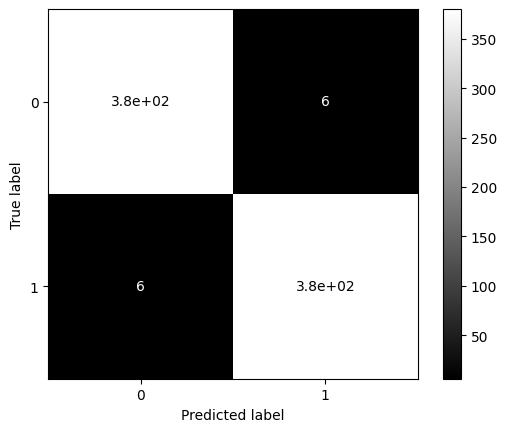

In [472]:
X_test = tfidf.fit_transform(X_test)
#all of the scikit-learn transformers maintain samples' ordering
X_test = StandardScaler().fit_transform(X_test.todense())
#No peeking!
dt = DecisionTreeClassifier(ccp_alpha=ccpa)
dt.fit(X_test, y_test.ravel())

preds = dt.predict(X_test)
print(dt.score(X_test, y_test))
print(metrics.precision_score(y_test, preds), metrics.recall_score(y_test, preds))
fig = plt.figure(figsize=(4,4))
metrics.plot_confusion_matrix(dt, X_test, y_test, cmap="gray")
plt.savefig("matrixtree.png")
files.download("matrixtree.png")

a single tree matches performance of random forest for tags

it does well on 0s (lates) but classifies way too many earlies as lates

In [470]:
y_test.shape

(771,)

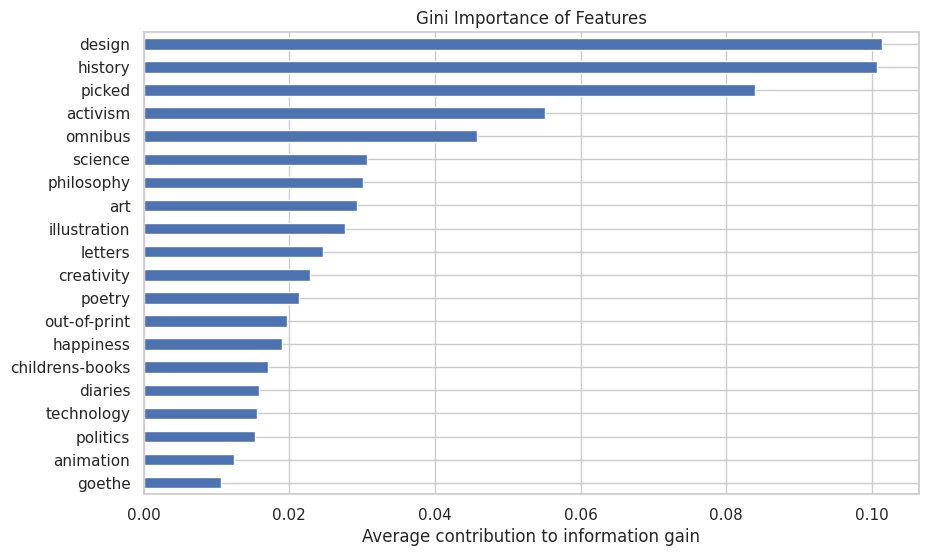

In [474]:
feat_scores = pd.Series(dt.feature_importances_, index=tfidf.get_feature_names())
feat_scores = feat_scores.sort_values()
sns.set_theme(style="whitegrid")
ax = feat_scores[-20:].plot(kind='barh', figsize=(10,6))
ax.set_title('Gini Importance of Features')
ax.set_xlabel('Average contribution to information gain');
#partial dependence plots for class-wise features
#see RF pm lacture
#cross tab/pivot tables of counts


In [545]:
for ix, x in enumerate(tfidf.get_feature_names()):
  if x in ["design", "history", "activism", "activism", "omnibus", "science", "philosophy", "art", "poetry"]:
    print(x, ix)

activism 8
art 64
design 173
history 301
omnibus 498
philosophy 525
poetry 531
science 586


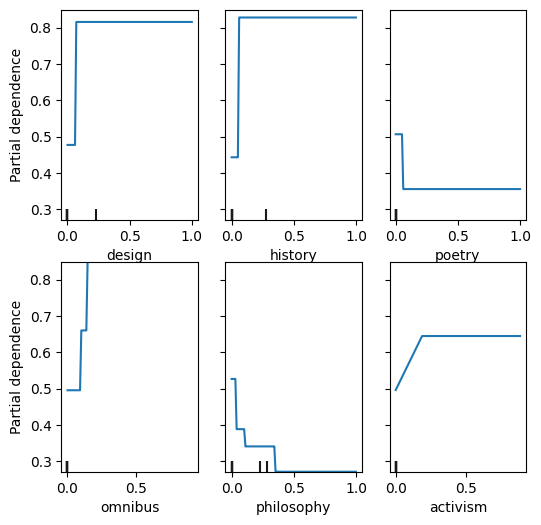

In [548]:

#You can access the newly created figure and Axes objects using plt.gcf() and plt.gca()
#pd = predicted probability of class 1, x-axis is tfidf score
fig, ax = plt.subplots(figsize=(6,6))
plot_partial_dependence(dt, X_train.A, features=[173, 301, 531, 498, 525, 8],
                        feature_names=tfidf.get_feature_names(),
                        target=1, ax=ax, n_jobs=3, grid_resolution=100, percentiles=(0, 1));

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
plot_partial_dependence(dt, X_train.A, features=[(301,525)],
                        feature_names=tfidf.get_feature_names(),
                        target=1, ax=ax, n_jobs=3, grid_resolution=100, percentiles=(0, 1));

#### 1.3.2 Random forest

In [491]:
rf = RandomForestClassifier(n_estimators=400, criterion="entropy")
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [364]:
scores = cross_val_score(estimator=rf, X=X_train, y=y_train)
print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.856 accuracy with a standard deviation of 0.01


In [ ]:
rf.get_params()

0.9844357976653697


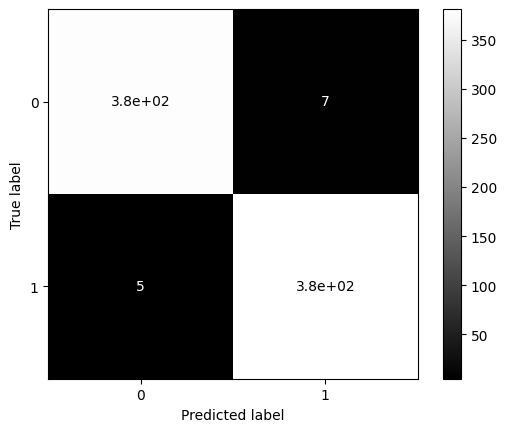

In [365]:
X_test = tfidf.fit_transform(X_test)
#all of the scikit-learn transformers maintain samples' ordering
X_test = StandardScaler().fit_transform(X_test.todense())
#No peeking!
rf = RandomForestClassifier(n_estimators=400, criterion="entropy")
rf.fit(X_test, y_test.ravel())
preds = rf.predict(X_test)

print(rf.score(X_test, y_test))
metrics.plot_confusion_matrix(rf, X_test, y_test, cmap="gray")

In [ ]:
param_grid = {'n_estimators': [100],
              'max_features': ['sqrt', 'log2'],
              'max_depth' : [15, 20, 25], #original 6,9,12
              'criterion' : ['gini', 'entropy']}
clf = GridSearchCV(RandomForestClassifier(random_state=36), param_grid, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_params_)

* life       15044
* world      10759
* time       10645
* art        10007
* love          9940
* human         8346
* book          7827
* people       7814
* work         7214
* science      5883
* mind              4762
* creative          4700


#### 1.3.3 Naive Bayes

For shits and gigs. Features are dependent, no?

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

In [ ]:
print(nb.score(X_test, y_test))
plot_confusion_matrix(nb, X_test, y_test, cmap="gray", colorbar=False);

#### 1.3.4 Spacy 

In [ ]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

### 2. A multi-label problem
#### Make classes based on tags

In [ ]:
art, science, love, poetry, cinema, philosophy, psychology  = [],[],[],[],[],[],[]

for ix, tag in enumerate(df.tags):
    if re.match(".* art,.*", tag) or re.match("art,.*", tag): art.append(ix)

for ix, tag in enumerate(df.tags):
    if re.match(".*science,.*", tag): science.append(ix)

In [ ]:
art_df=df.iloc[art]
art_df["art"]=1

sci_df=df.iloc[science]
sci_df["art"]=0

df = pd.concat([art_df, sci_df])

# ~250 articles are duplicates, tagged both art and science
# I remove them but is it a multi-label problem?
df=df[df.index.value_counts()==1]
df2=df2.reset_index(drop=True)

### Science/art tag classes

In [ ]:
y = df2.art
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2,
                                                    stratify=y, random_state=36)

In [ ]:
X_train.shape

In [ ]:
#oversample science class
X_train, y_train = SMOTE().fit_resample(X_train, y_train.ravel())

In [ ]:
X_train.shape

### Logistic regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
preds = lr.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))

In [ ]:
plot_confusion_matrix(lr, X_test, y_test);

### EXTRA: Spacy

In [ ]:
nlp = en_core_web_sm.load()
# Process whole documents
doc = nlp(df.content[1111])

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)
    
sentence_spans = list(doc.sents)

In [ ]:
displacy.serve(sentence_spans[3], style="ent")

In [ ]:
displacy.serve(sentence_spans[3], style="dep", options={"compact":True, "color":"#FFFFFF", "bg":"#448ee4"})

### NMF (unsupervised)

In [ ]:
nmf = NMF(n_components=4, max_iter=400)
nmf.fit(X)

In [ ]:
H = nmf.components_
H.shape

In [ ]:
for i, row in enumerate(H):
    top = np.argsort(row)[::-1][:15]
    print(i, ', '.join(vocabulary[top]))

### Stop the presses, random forest 90 percent accurate tag classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15)
rf.fit(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)
plot_confusion_matrix(rf, X_test, y_test);

In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

In [ ]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=vocabulary)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', 
                      figsize=(7,5),
                      color='r')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [ ]:
clf = GradientBoostingClassifier(n_estimators=500,
                                 learning_rate=0.05,
                                 max_depth=20, random_state=36).fit(X_train, y_train)
clf.score(X_test, y_test)